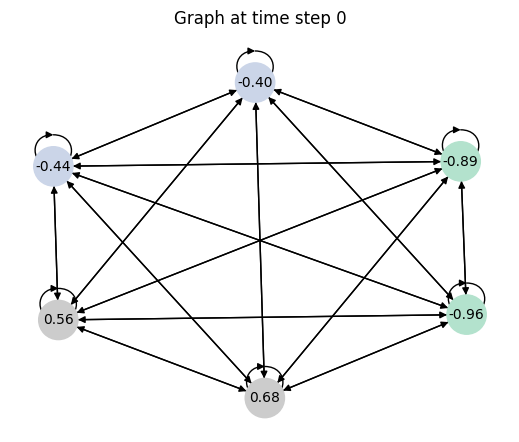

In [431]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

def visualize_graph(data: Data, t: int = 0):
    G = to_networkx(data)
    x = data.x[0, t, :, 0].numpy()
    pos = nx.spring_layout(G, seed=42)

    fig = plt.figure(figsize=(5, 4))
    nx.draw(G, pos, node_color=x, cmap='Pastel2', node_size=800)
    
    labels = {i: f"{y:.2f}" for i, y in enumerate(x)}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
    
    fig.gca().set_title(f"Graph at time step {t}")
    return fig

def generate_temporal_graphs(
    graphs: int = 8,
    cycles: float = 2, 
    steps_per_cycle: int = 32,
    num_nodes: int = 6,
    std: float = 0.0,
):
    S = int(cycles * steps_per_cycle)
    t = torch.linspace(0, cycles, S)
    X = torch.zeros((graphs, S, num_nodes, 1))
    phases = torch.tensor(np.linspace(0, 1, num_nodes, endpoint=False))
    phases = (phases[None, :] + torch.rand((graphs, num_nodes)))
    
    T = t[None, :, None, None] + phases[:, None, :, None]    
    P = (T + torch.rand(graphs, 1, 1, 1) / 2)
    X = torch.sin(P * 2 * torch.pi) + torch.randn_like(T) * std
    
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()
    self_loops = torch.arange(num_nodes).unsqueeze(0).repeat(2,1)
    edge_index = torch.cat([edge_index, edge_index.flip(0), self_loops], dim=1)
    edge_weight = torch.ones(edge_index.size(1))
    data = Data(x=X.to(torch.float32), edge_index=edge_index, edge_weight=edge_weight)
    return data, P

G, _ = generate_temporal_graphs(graphs=5)
visualize_graph(G)
plt.show()

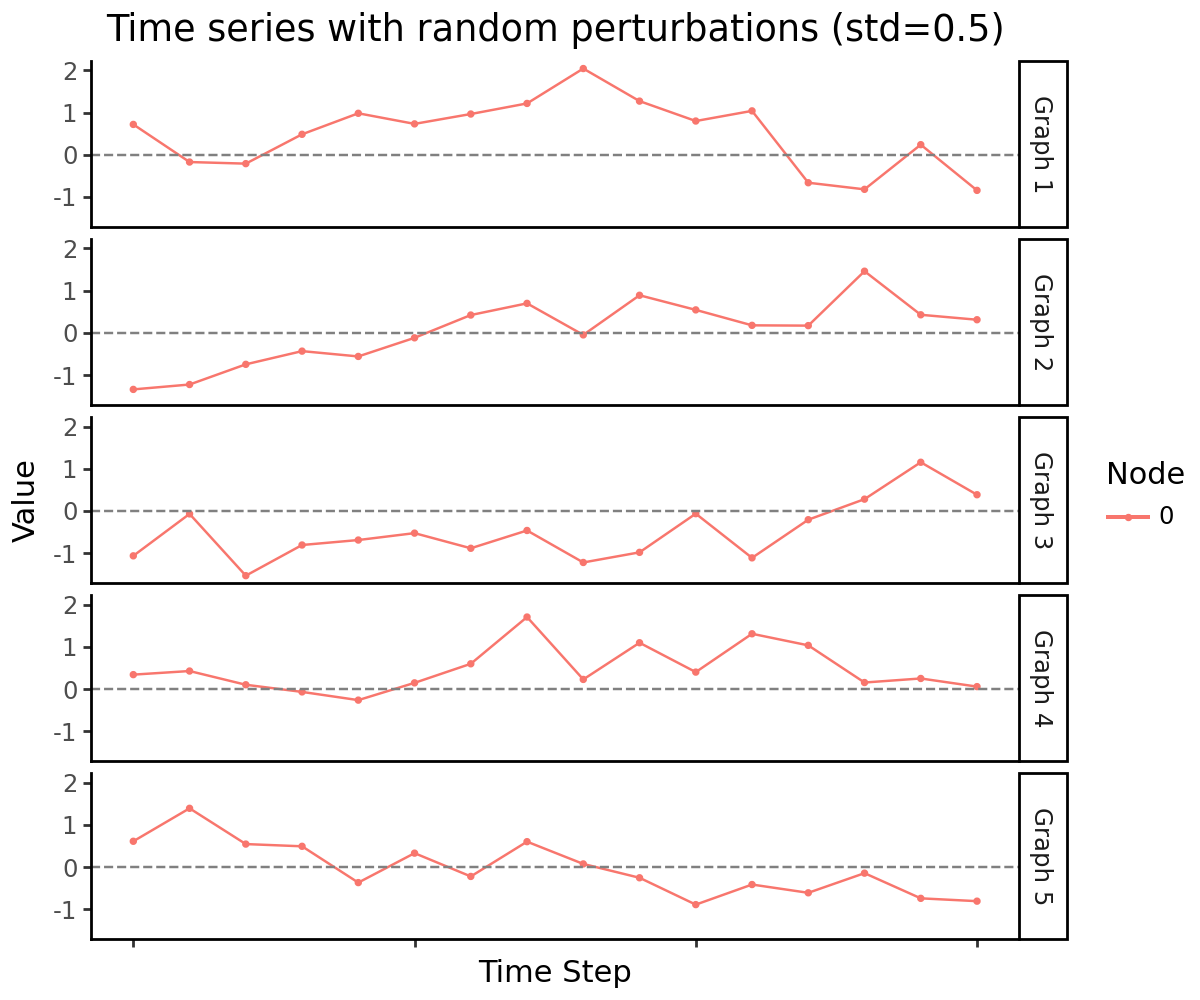

In [449]:
import pandas as pd
from plotnine import *

def plot_graph_time_series(data: Data):
    X = data.x.transpose(1, 2).squeeze(-1).numpy()

    graphs, nodes, steps = X.shape
    T = np.tile(np.arange(steps), graphs * nodes)
    N = np.tile(np.repeat(np.arange(nodes), steps), graphs)
    G = np.repeat(np.arange(graphs), nodes * steps)
    df = pd.DataFrame({
        'Time Step': T,
        'Node': map(str, N),
        'Graph': [f'Graph {g+1}' for g in G],
        'Value': X.reshape(-1)
    })

    return (ggplot(df, aes(x='Time Step', y='Value', color='Node')) 
        + facet_grid('Graph ~ .')
        + geom_line(aes(group='Node'))
        + geom_point(size=0.5)
        + geom_hline(yintercept=0, color='gray', linetype='dashed')
        + theme_classic()
        + theme(axis_text_x=element_blank(), figure_size=(6, 5)))

std = 0.5
data, _ = generate_temporal_graphs(graphs=5, cycles=0.5, num_nodes=1, std=std)
plot_graph_time_series(data) + ggtitle(f'Time series with random perturbations (std={std})')

In [478]:
from torch_geometric_temporal import BatchedDCRNN
from tqdm.notebook import tqdm

NEXT_STEPS = 24

def train(data: Data, val_data: Data, num_epochs, emb_dim, next_steps, K=1):
    B, S, N, D = data.x.shape

    encoder = BatchedDCRNN(in_channels=1, out_channels=emb_dim, K=K)
    decoder = torch.nn.Linear(emb_dim * (S - next_steps) * D, next_steps * 1)
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-2)

    bar = tqdm(range(num_epochs))
    X, X_val = data.x[:, :-next_steps], val_data.x[:, :-next_steps]
    y, y_val = data.x[:, -next_steps:], val_data.x[:, -next_steps:]

    for _ in bar:
        encoder.train()
        
        emb = encoder(X, edge_index=data.edge_index, edge_weight=data.edge_weight)
        emb = emb.transpose(1, 2).reshape(B, N, -1)
        
        y_pred = decoder(emb).transpose(1, 2).unsqueeze(-1)
    
        loss = torch.nn.functional.mse_loss(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        encoder.eval()
        
        val_emb = encoder(X_val, edge_index=val_data.edge_index, edge_weight=val_data.edge_weight)
        val_emb = val_emb.transpose(1, 2).reshape(X_val.size(0), N, -1)
        y_val_pred = decoder(val_emb).transpose(1, 2).unsqueeze(-1)
        val_loss = torch.nn.functional.mse_loss(y_val_pred, y_val)
        
        bar.set_description(f'Loss: {val_loss.item():.4f}')
        
    return encoder, decoder

data, _ = generate_temporal_graphs(graphs=128, cycles=1, std=0.5)
val_data, _ = generate_temporal_graphs(graphs=16, cycles=1, std=0.0)
encoder, decoder = train(data, val_data, num_epochs=50, emb_dim=2, next_steps=NEXT_STEPS)

  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1, 8, 6, 1])
torch.Size([1, 24, 6, 1])


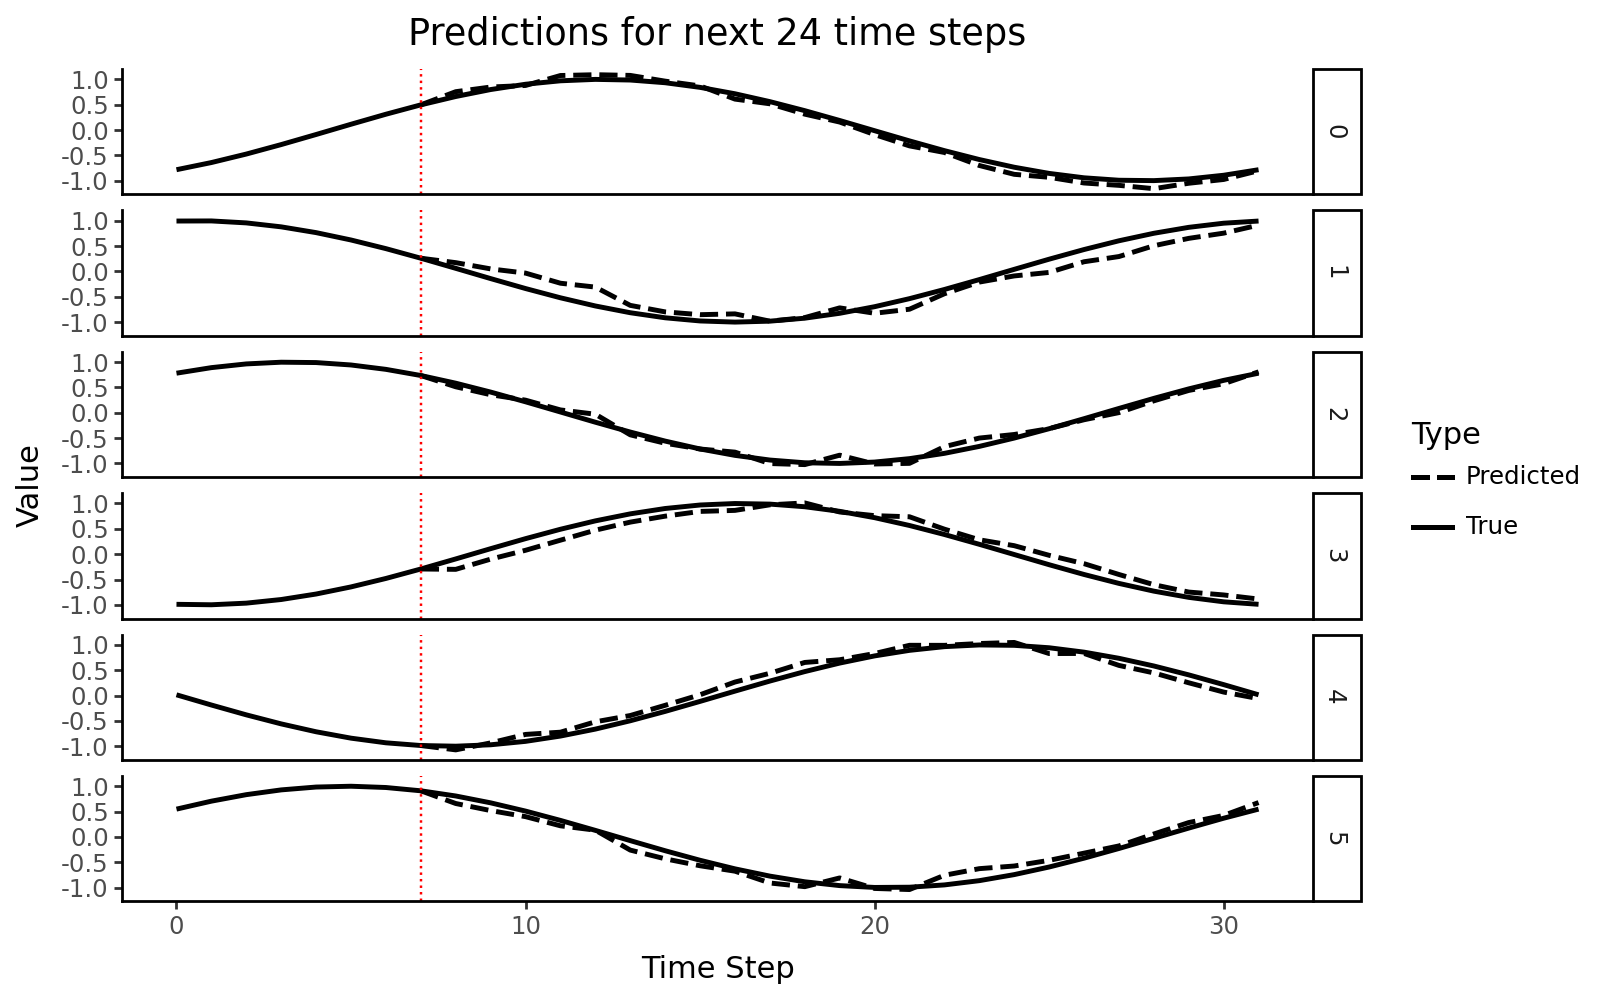

In [ ]:
def visualize_predictions(encoder, decoder, data: Data, next_steps):
    B, S, N, D = data.x.shape
    assert B == 1
        
    X = data.x[:, :-next_steps]
    
    emb = encoder(X, edge_index=data.edge_index, edge_weight=data.edge_weight)
    emb = emb.transpose(1, 2).reshape(1, N, -1)
    y_pred = decoder(emb).transpose(1, 2).unsqueeze(-1)
    
    x = data.x[0, :, :, 0].detach().numpy().T
    y_pred = y_pred[0, :, :, 0].detach().numpy().T
    y_pred = np.concatenate([x[:, -next_steps-1][:, None], y_pred], axis=1)
    return x, y_pred

graph = generate_temporal_graphs(graphs=1, cycles=1, std=0.0)[0]
x, y_pred = visualize_predictions(encoder, decoder, graph, next_steps=NEXT_STEPS)
t = np.concatenate([np.arange(x.shape[1]), np.arange(x.shape[1])[-y_pred.shape[1]:]])
type_ = ['True'] * x.shape[1] + ['Predicted'] * y_pred.shape[1]

df = pd.DataFrame({
    'Time Step': np.tile(t, x.shape[0]),
    'Node': np.repeat(np.arange(x.shape[0]), t.shape[0]),
    'Value': np.concatenate([x, y_pred], axis=1).reshape(-1).tolist(),
    'Type': np.tile(type_, x.shape[0]),
})

(ggplot(df, aes(x='Time Step', y='Value', linetype='Type'))
    + facet_grid('Node ~ .')
    + geom_line(aes(group='Type'), size=1)
    + geom_vline(xintercept=x.shape[1]-NEXT_STEPS-1, linetype='dotted', color='RED')
    + scale_linetype_manual(values=['dashed', 'solid'])
    + theme_classic() + theme(figure_size=(8, 5))
    + ggtitle(f'Predictions for next {NEXT_STEPS} time steps')
)

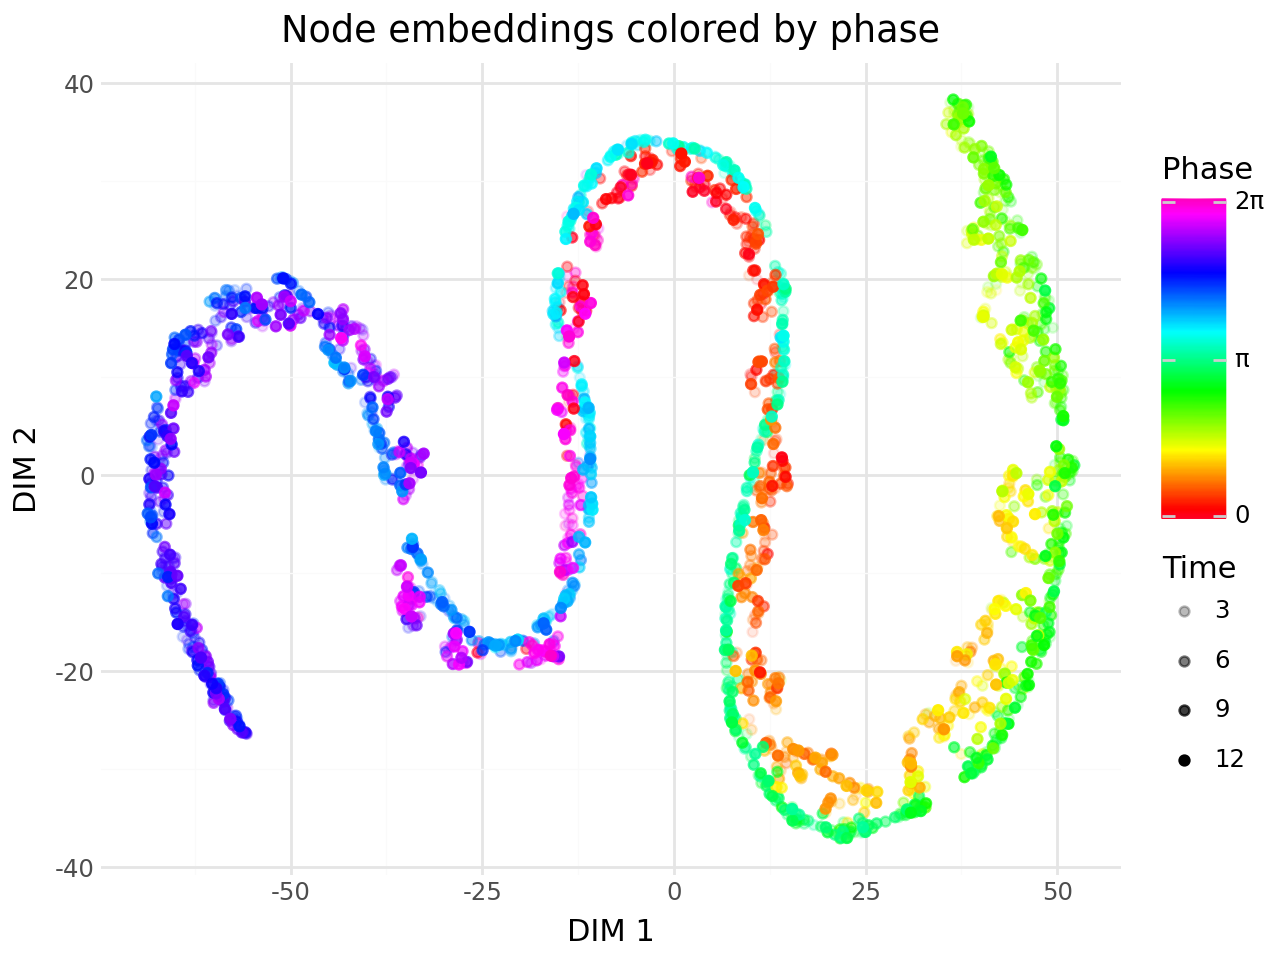

In [459]:
from sklearn.manifold import TSNE

val_data, T = generate_temporal_graphs(graphs=1, cycles=10, std=0.3)

encoder.eval()
emb = encoder(val_data.x, edge_index=val_data.edge_index, edge_weight=val_data.edge_weight)
emb = emb.detach().squeeze(0).numpy()
emb = emb.reshape(-1, emb.shape[-1])

proj = TSNE(n_components=2)
emb_2d = proj.fit_transform(emb)

time = T.view(-1).numpy()
df = pd.DataFrame({'DIM 1': emb_2d[:, 0], 'DIM 2': emb_2d[:, 1], 'Time': time, 'Phase': time % 1})

(
    ggplot(df, aes(x='DIM 1', y='DIM 2', alpha='Time', color='Phase')) 
    + geom_point()
    + scale_color_continuous(
        cmap_name='gist_rainbow', 
        breaks=[0.01, 0.5, 0.99], 
        labels=['0', 'π', '2π'])
    + theme_minimal()
    + ggtitle('Node embeddings colored by phase')
)